# Natural Language Processing: Week 4 - Sequence models and literature

앞서 배운 Sequence Model을 이용하여 새로운 text를 생성하는 것을 생각해보자.

이는 굉장히 어렵고 새로운 것처럼 보이지만, 사실 이에 필요한 모든 것을 우리는 이미 배웠다.

새로운 것을 생성하는 것이 아니라, '다음에 올 단어를 예측'하는 예측 문제라고 생각해보자. 전체 phrase로부터 단어들을 추출해 dataset을 형성한 후 X라는 만들어진 phrase와 그 뒤에 올 Y를 예측해나가면 된다.

많은 단어들을 이용하여 신경망을 학습시킨다면 꽤나 복잡한 문장 또한 생성할 수 있을 것이다.

## Import packages

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 

## Tokenizer and data


In [4]:
tokenizer = Tokenizer()

data="In the town of Athy one Jeremy Lanigan \n Battered away til he hadnt a pound. \nHis father died and made him a man again \n Left him a farm and ten acres of ground. \nHe gave a grand party for friends and relations \nWho didnt forget him when come to the wall, \nAnd if youll but listen Ill make your eyes glisten \nOf the rows and the ructions of Lanigans Ball. \nMyself to be sure got free invitation, \nFor all the nice girls and boys I might ask, \nAnd just in a minute both friends and relations \nWere dancing round merry as bees round a cask. \nJudy ODaly, that nice little milliner, \nShe tipped me a wink for to give her a call, \nAnd I soon arrived with Peggy McGilligan \nJust in time for Lanigans Ball. \nThere were lashings of punch and wine for the ladies, \nPotatoes and cakes; there was bacon and tea, \nThere were the Nolans, Dolans, OGradys \nCourting the girls and dancing away. \nSongs they went round as plenty as water, \nThe harp that once sounded in Taras old hall,\nSweet Nelly Gray and The Rat Catchers Daughter,\nAll singing together at Lanigans Ball. \nThey were doing all kinds of nonsensical polkas \nAll round the room in a whirligig. \nJulia and I, we banished their nonsense \nAnd tipped them the twist of a reel and a jig. \nAch mavrone, how the girls got all mad at me \nDanced til youd think the ceiling would fall. \nFor I spent three weeks at Brooks Academy \nLearning new steps for Lanigans Ball. \nThree long weeks I spent up in Dublin, \nThree long weeks to learn nothing at all,\n Three long weeks I spent up in Dublin, \nLearning new steps for Lanigans Ball. \nShe stepped out and I stepped in again, \nI stepped out and she stepped in again, \nShe stepped out and I stepped in again, \nLearning new steps for Lanigans Ball. \nBoys were all merry and the girls they were hearty \nAnd danced all around in couples and groups, \nTil an accident happened, young Terrance McCarthy \nPut his right leg through miss Finnertys hoops. \nPoor creature fainted and cried Meelia murther, \nCalled for her brothers and gathered them all. \nCarmody swore that hed go no further \nTil he had satisfaction at Lanigans Ball. \nIn the midst of the row miss Kerrigan fainted, \nHer cheeks at the same time as red as a rose. \nSome of the lads declared she was painted, \nShe took a small drop too much, I suppose. \nHer sweetheart, Ned Morgan, so powerful and able, \nWhen he saw his fair colleen stretched out by the wall, \nTore the left leg from under the table \nAnd smashed all the Chaneys at Lanigans Ball. \nBoys, oh boys, twas then there were runctions. \nMyself got a lick from big Phelim McHugh. \nI soon replied to his introduction \nAnd kicked up a terrible hullabaloo. \nOld Casey, the piper, was near being strangled. \nThey squeezed up his pipes, bellows, chanters and all. \nThe girls, in their ribbons, they got all entangled \nAnd that put an end to Lanigans Ball."

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [5]:
print(tokenizer.word_index)
print(total_words)

{'and': 1, 'the': 2, 'a': 3, 'in': 4, 'all': 5, 'i': 6, 'for': 7, 'of': 8, 'lanigans': 9, 'ball': 10, 'were': 11, 'at': 12, 'to': 13, 'she': 14, 'stepped': 15, 'his': 16, 'girls': 17, 'as': 18, 'they': 19, 'til': 20, 'he': 21, 'again': 22, 'got': 23, 'boys': 24, 'round': 25, 'that': 26, 'her': 27, 'there': 28, 'three': 29, 'weeks': 30, 'up': 31, 'out': 32, 'him': 33, 'was': 34, 'spent': 35, 'learning': 36, 'new': 37, 'steps': 38, 'long': 39, 'away': 40, 'left': 41, 'friends': 42, 'relations': 43, 'when': 44, 'wall': 45, 'myself': 46, 'nice': 47, 'just': 48, 'dancing': 49, 'merry': 50, 'tipped': 51, 'me': 52, 'soon': 53, 'time': 54, 'old': 55, 'their': 56, 'them': 57, 'danced': 58, 'dublin': 59, 'an': 60, 'put': 61, 'leg': 62, 'miss': 63, 'fainted': 64, 'from': 65, 'town': 66, 'athy': 67, 'one': 68, 'jeremy': 69, 'lanigan': 70, 'battered': 71, 'hadnt': 72, 'pound': 73, 'father': 74, 'died': 75, 'made': 76, 'man': 77, 'farm': 78, 'ten': 79, 'acres': 80, 'ground': 81, 'gave': 82, 'grand':

In [6]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [7]:
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['town'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['athy'])
print(tokenizer.word_index['one'])
print(tokenizer.word_index['jeremy'])
print(tokenizer.word_index['lanigan'])

4
2
66
8
67
68
69
70


In [8]:
print(xs[5])
print(ys[5])

[ 0  0  0  0  4  2 66  8 67 68]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
print(tokenizer.word_index)

{'and': 1, 'the': 2, 'a': 3, 'in': 4, 'all': 5, 'i': 6, 'for': 7, 'of': 8, 'lanigans': 9, 'ball': 10, 'were': 11, 'at': 12, 'to': 13, 'she': 14, 'stepped': 15, 'his': 16, 'girls': 17, 'as': 18, 'they': 19, 'til': 20, 'he': 21, 'again': 22, 'got': 23, 'boys': 24, 'round': 25, 'that': 26, 'her': 27, 'there': 28, 'three': 29, 'weeks': 30, 'up': 31, 'out': 32, 'him': 33, 'was': 34, 'spent': 35, 'learning': 36, 'new': 37, 'steps': 38, 'long': 39, 'away': 40, 'left': 41, 'friends': 42, 'relations': 43, 'when': 44, 'wall': 45, 'myself': 46, 'nice': 47, 'just': 48, 'dancing': 49, 'merry': 50, 'tipped': 51, 'me': 52, 'soon': 53, 'time': 54, 'old': 55, 'their': 56, 'them': 57, 'danced': 58, 'dublin': 59, 'an': 60, 'put': 61, 'leg': 62, 'miss': 63, 'fainted': 64, 'from': 65, 'town': 66, 'athy': 67, 'one': 68, 'jeremy': 69, 'lanigan': 70, 'battered': 71, 'hadnt': 72, 'pound': 73, 'father': 74, 'died': 75, 'made': 76, 'man': 77, 'farm': 78, 'ten': 79, 'acres': 80, 'ground': 81, 'gave': 82, 'grand':

In [10]:
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(xs, ys, epochs=500, verbose=1)

Epoch 1/500
15/15 [==============================] - 4s 11ms/step - loss: 5.5661 - accuracy: 0.0464
Epoch 2/500
15/15 [==============================] - 0s 9ms/step - loss: 5.5339 - accuracy: 0.0486
Epoch 3/500
15/15 [==============================] - 0s 9ms/step - loss: 5.4605 - accuracy: 0.0486
Epoch 4/500
15/15 [==============================] - 0s 9ms/step - loss: 5.2873 - accuracy: 0.0486
Epoch 5/500
15/15 [==============================] - 0s 8ms/step - loss: 5.1241 - accuracy: 0.0486
Epoch 6/500
15/15 [==============================] - 0s 9ms/step - loss: 5.0628 - accuracy: 0.0486
Epoch 7/500
15/15 [==============================] - 0s 9ms/step - loss: 5.0257 - accuracy: 0.0486
Epoch 8/500
15/15 [==============================] - 0s 8ms/step - loss: 4.9874 - accuracy: 0.0486
Epoch 9/500
15/15 [==============================] - 0s 8ms/step - loss: 4.9559 - accuracy: 0.0662
Epoch 10/500
15/15 [==============================] - 0s 9ms/step - loss: 4.9199 - accuracy: 0.0618
Epoch 11

## Visualize

In [11]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

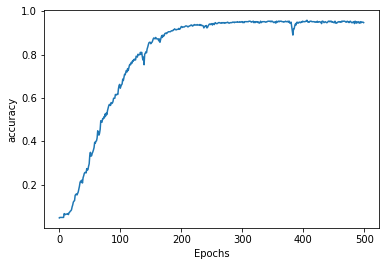

In [12]:
plot_graphs(history, 'accuracy')

### Generate new text

In [24]:
seed_text = "Laurence went to dublin"
next_words = 100

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  # in TF 2.5.x
  # predicted = model.predict_classes(token_list, verbose=0) 

  # in TF 2.6 above
  predict_x = model.predict(token_list, verbose=0)
  predicted=np.argmax(predict_x,axis=1)

  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

Laurence went to dublin that nice little milliner fall fair fair colleen colleen round his wall wall wall wall from phelim entangled entangled entangled entangled entangled entangled entangled odaly me me a minute both for lanigans ball ball ball a painted strangled strangled hall father call right no further father ask father ask ask father ask ask suppose suppose suppose suppose replied i again again me up again again again relations relations relations hearty hearty hearty entangled mavrone me a minute both friends and friends and friends and relations relations relations relations i being hall hall hall hall hall them ask forget at wall


~~What the fuxk~~